In [ ]:
# import libraries
!pip install pyforest
!pip install pytz
!pip install pmdarima
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyforest import *
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from datetime import datetime
import datetime, pytz
import gc
import warnings
warnings.filterwarnings('ignore')
lazy_imports()

['import statistics',
 'from sklearn.model_selection import train_test_split',
 'from pyspark import SparkContext',
 'import gensim',
 'from sklearn.model_selection import StratifiedKFold',
 'from scipy import stats',
 'from sklearn.ensemble import RandomForestClassifier',
 'from sklearn.linear_model import ElasticNet',
 'import bokeh',
 'from scipy import signal as sg',
 'from PIL import Image',
 'from sklearn.model_selection import cross_val_score',
 'import numpy as np',
 'from openpyxl import load_workbook',
 'from sklearn.preprocessing import RobustScaler',
 'from sklearn.manifold import TSNE',
 'import tqdm',
 'import lightgbm as lgb',
 'import plotly.express as px',
 'from xlrd import open_workbook',
 'from fbprophet import Prophet',
 'import sklearn',
 'import glob',
 'from sklearn import svm',
 'from sklearn.preprocessing import StandardScaler',
 'from sklearn.ensemble import RandomForestRegressor',
 'import fastai',
 'import awswrangler as wr',
 'import re',
 'import cv2',
 '

In [ ]:
#read csv
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

df_bitcoin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dana 4810 Time Series Bitcoin/dataset/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv'
    , header = 0,index_col = 0,parse_dates = [0], date_parser = dateparse)
df_bitcoin.head()

<IPython.core.display.Javascript object>

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 05:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-12-01 05:34:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:36:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-01 05:37:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# converting Timestamp to datetime
df_bitcoin.index = pd.to_datetime(df_bitcoin.index)
df_bitcoin.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2016354 entries, 2014-12-01 05:33:00+00:00 to 2018-11-11 00:00:00+00:00
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 123.1 MB


In [ ]:
#date range
print('start date: ',min(df_bitcoin.index.date))
print('end date: ',max(df_bitcoin.index.date))
print('Number of years: ',
      (max(df_bitcoin.index.year) - min(df_bitcoin.index.year)))

start date:  2014-12-01
end date:  2018-11-11
Number of years:  4


In [ ]:
#checking for null values
df_bitcoin.isnull().sum()

Open                 108957
High                 108957
Low                  108957
Close                108957
Volume_(BTC)         108957
Volume_(Currency)    108957
Weighted_Price       108957
dtype: int64

In [ ]:
# fixing null with zeros and bfill
# creating copy of the dataframe
df_bit2 = df_bitcoin.copy()

"""based on the analysis, the volumns are individual events, they do not increment over time,
so we will fill na values with zero"""

df_bit2['Volume_(BTC)'] = df_bit2['Volume_(BTC)'].fillna(value = 0)
df_bit2['Volume_(Currency)'] = df_bit2['Volume_(Currency)'].fillna(value = 0)

df_bit2['Weighted_Price'] = df_bit2['Weighted_Price'].fillna(value = 0)

"""The following parameters are incremented/ dependent on each time steps,
hence we will fill na values with backward fill """

df_bit2['Open'] = df_bit2['Open'].fillna(method = 'bfill')
df_bit2['High'] = df_bit2['High'].fillna(method = 'bfill')
df_bit2['Low'] = df_bit2['Low'].fillna(method = 'bfill')
df_bit2['Close'] = df_bit2['Close'].fillna(method = 'bfill')

df_bit2.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 05:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-12-01 05:34:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2014-12-01 05:35:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2014-12-01 05:36:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2014-12-01 05:37:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [ ]:
# Data prep for model input
# resampling data into daily and hourly again for seasonal decompose and analysis
data_prep = df_bit2.copy()
data_prep_hourly = data_prep.groupby(pd.Grouper(level = 'Timestamp', freq = 'H')).first()
data_prep_daily = data_prep.groupby(pd.Grouper(level = 'Timestamp', freq = 'D')).first()

data_prep_hourly['Weighted_Price'] = data_prep_hourly['Weighted_Price'].replace(0,np.nan)
data_prep_hourly['Weighted_Price'] = data_prep_hourly['Weighted_Price'].fillna(method = 'bfill')
data_prep_daily['Weighted_Price'] = data_prep_daily['Weighted_Price'].replace(0,np.nan)
data_prep_daily['Weighted_Price'] = data_prep_daily['Weighted_Price'].fillna(method = 'bfill')

data_prep_hourly['Volume_(BTC)'] = data_prep_hourly['Volume_(BTC)'].fillna(0)
data_prep_daily['Volume_(BTC)'] = data_prep_daily['Volume_(BTC)'].fillna(0)

data_prep_hourly['Volume_(Currency)'] = data_prep_hourly['Volume_(Currency)'].fillna(0)
data_prep_daily['Volume_(Currency)'] = data_prep_daily['Volume_(Currency)'].fillna(0)

# our target = weighted price
data_prep_daily = data_prep_daily[['Volume_(BTC)','Volume_(Currency)','Weighted_Price']]
display(data_prep_hourly.head(10),data_prep_daily.head(10))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 05:00:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2014-12-01 06:00:00+00:00,370.0,370.0,370.0,370.0,0.00,0.0,378.0
2014-12-01 07:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0
2014-12-01 08:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0
2014-12-01 09:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0
2014-12-01 10:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0
2014-12-01 11:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0
2014-12-01 12:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0
2014-12-01 13:00:00+00:00,377.0,377.0,377.0,377.0,0.00,0.0,378.0


,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,
2014-12-01 00:00:00+00:00,0.010,3.0000,300.000000
2014-12-02 00:00:00+00:00,0.000,0.0000,378.000000
2014-12-03 00:00:00+00:00,0.000,0.0000,378.000000
2014-12-04 00:00:00+00:00,0.000,0.0000,378.000000
2014-12-05 00:00:00+00:00,0.000,0.0000,378.000000
2014-12-06 00:00:00+00:00,0.015,5.6700,378.000000
2014-12-07 00:00:00+00:00,0.000,0.0000,375.000426
2014-12-08 00:00:00+00:00,0.235,88.1251,375.000426
2014-12-09 00:00:00+00:00,0.000,0.0000,398.000000


In [ ]:
# data divison (05-jun-2018) as raise started after major dip (DAILY)
data_division = '2018-06-04'
bit_train2 = data_prep_daily[data_prep_daily.index <= data_division]
bit_test2 = data_prep_daily[data_prep_daily.index > data_division]
bit_train2.head()

,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,
2014-12-01 00:00:00+00:00,0.01,3.0,300.0
2014-12-02 00:00:00+00:00,0.00,0.0,378.0
2014-12-03 00:00:00+00:00,0.00,0.0,378.0
2014-12-04 00:00:00+00:00,0.00,0.0,378.0
2014-12-05 00:00:00+00:00,0.00,0.0,378.0


<IPython.core.display.Javascript object>

Dickey–Fuller test: p=0.497411


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

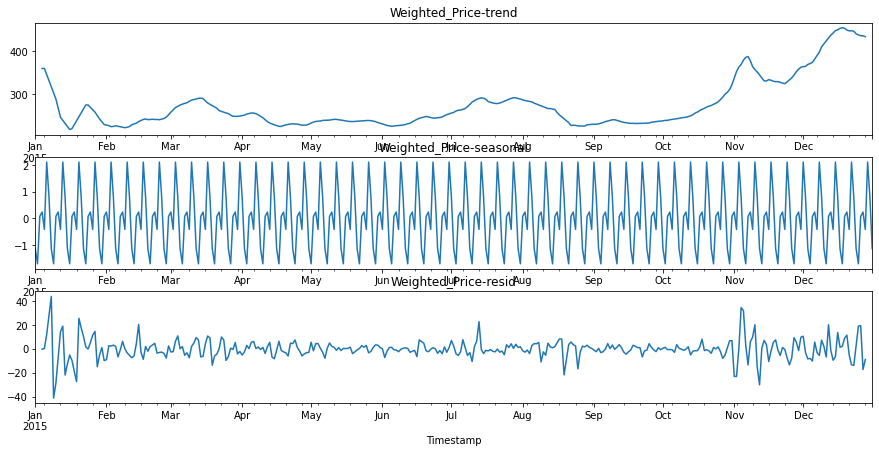

In [ ]:
# seasonal decompose 
plt.figure(figsize=[15,7])
bit_train_2015 = bit_train2[(bit_train2.index >= '2015-01-01') & (bit_train2.index <= '2015-12-31')]
result_decompose2 = sm.tsa.seasonal_decompose(bit_train_2015.Weighted_Price,model = 'additive')
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(bit_train2.Weighted_Price)[1])

plt.subplot(311)
result_decompose2.trend.plot()
plt.title("Weighted_Price-trend")

plt.subplot(312)
result_decompose2.seasonal.plot()
plt.title("Weighted_Price-seasonal")

plt.subplot(313)
result_decompose2.resid.plot()
plt.title("Weighted_Price-resid")

plt.show()

In [ ]:
# Data preprocess
bit_train_lstm = bit_train2[['Weighted_Price']].copy()
bit_test_lstm = bit_test2[['Weighted_Price']].copy()

# Data preprocess
training_set = bit_train_lstm.values
training_set = np.reshape(training_set, (len(training_set), 1))
testing_set = bit_test_lstm.values
testing_set = np.reshape(testing_set, (len(testing_set), 1))
print(training_set.shape,testing_set.shape)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(1282, 1) (160, 1)


In [ ]:
# scaler
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

<IPython.core.display.Javascript object>

In [ ]:
# reshape as per lstm
X_train = np.reshape(X_train, (len(X_train), 1, 1))
X_train.shape

<IPython.core.display.Javascript object>

(1281, 1, 1)

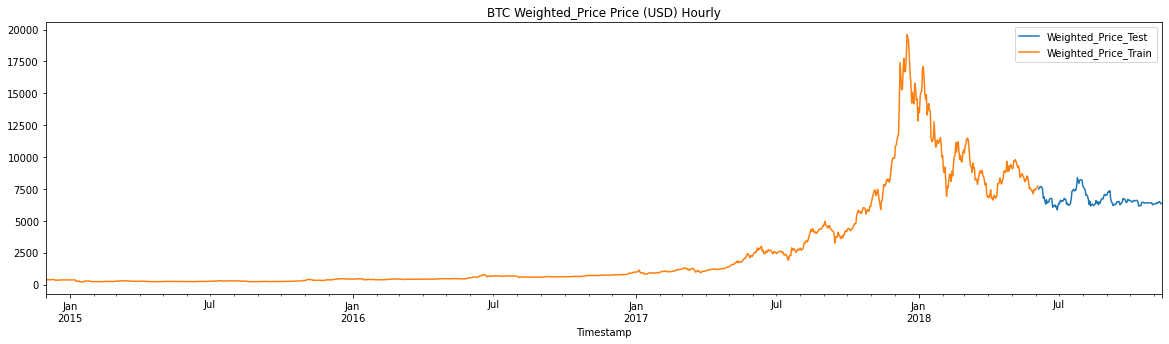

In [ ]:
# test train split graph
bit_test_lstm.rename(columns = {'Weighted_Price':'Weighted_Price_Test'}).join(
    bit_train_lstm.rename(columns = {'Weighted_Price':'Weighted_Price_Train'}), how = 'outer').plot(figsize = (20,5), 
                                                            title='BTC Weighted_Price Price (USD) Hourly', style='')

In [ ]:
# LSTM
# Vanila LSTM (Long stort term memory)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation,Flatten
from keras.callbacks import EarlyStopping

LSTM_model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(50 , activation='tanh', recurrent_activation='hard_sigmoid',
                    return_sequences = True,input_shape = (X_train.shape[1],1)))
LSTM_model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True))
LSTM_model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(Flatten())
LSTM_model.add(Dense(1))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

LSTM_model.compile(loss = 'mean_squared_error', optimizer = 'adam')
history = LSTM_model.fit(X_train,y_train, epochs = 200,
                         batch_size = 32, verbose = 1,shuffle = False,
                         validation_split=0.2, callbacks=[es])

Epoch 1/200
32/32 [==============================] - 8s 56ms/step - loss: 0.0014 - val_loss: 0.1947
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0040 - val_loss: 0.2266
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.2212
Epoch 4/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.2209
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.2210
Epoch 6/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.2208
Epoch 7/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.2206
Epoch 8/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.2204
Epoch 9/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.2200
Epoch 10/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.2196
Epoch 11

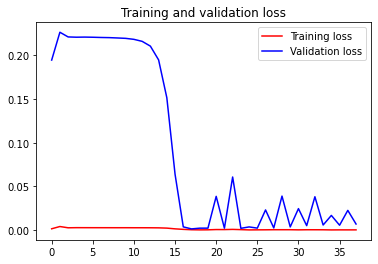

<Figure size 432x288 with 0 Axes>

In [ ]:
#### loss graph
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# summary
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [ ]:
testing_set.shape

(160, 1)

In [ ]:
# Making the predictions
testing_set = scaler.transform(testing_set)
testing_set = np.reshape(testing_set, (len(testing_set), 1, 1))

prediction_LSTM = LSTM_model.predict(testing_set)
prediction_LSTM = scaler.inverse_transform(prediction_LSTM)

prediction_LSTM_train = LSTM_model.predict(training_set)
prediction_LSTM_train = scaler.inverse_transform(prediction_LSTM_train)

bit_test_lstm['prediction_LSTM'] = prediction_LSTM
bit_train_lstm['prediction_LSTM_train'] = prediction_LSTM_train

print(bit_test2.shape,prediction_LSTM.shape)
print(bit_train2.shape,prediction_LSTM_train.shape)

<IPython.core.display.Javascript object>

(160, 3) (160, 1)
(1282, 3) (1282, 1)


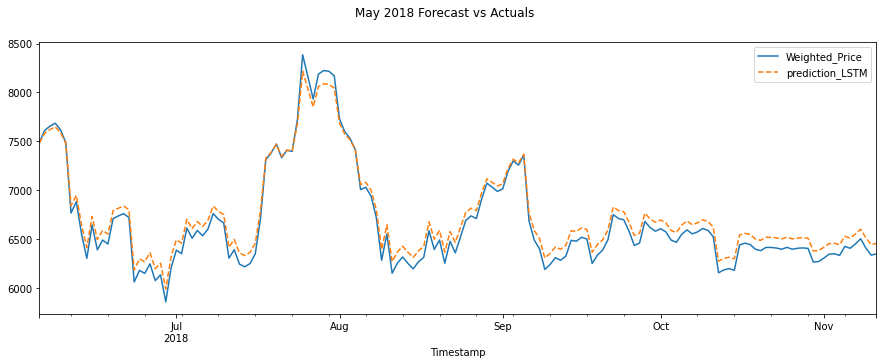

In [ ]:
# Plot the forecast with the actuals
fig , ax = plt.subplots(1, figsize = (15,5))
bit_test_lstm[['Weighted_Price','prediction_LSTM']].plot(ax = ax, style = ['-','--'])
#ax.set_xbound(lower = '2018-06-09', upper = '2018-06-23')
plt.suptitle("May 2018 Forecast vs Actuals")
plt.show()

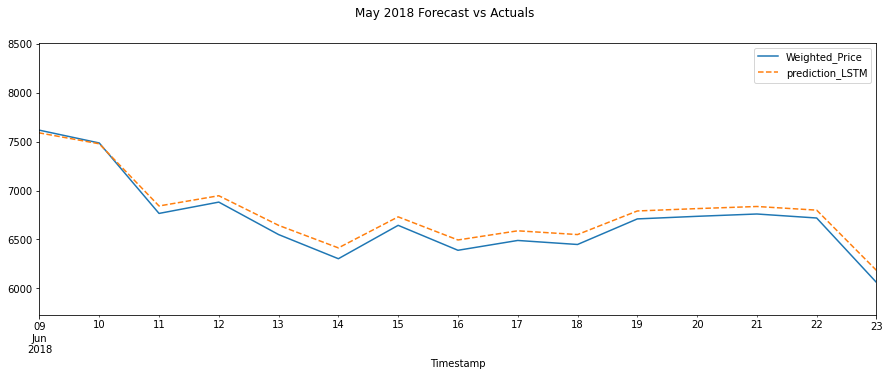

In [ ]:
# Plot the forecast with the actuals
fig , ax = plt.subplots(1, figsize = (15,5))
bit_test_lstm[['Weighted_Price','prediction_LSTM']].plot(ax = ax, style = ['-','--'])
ax.set_xbound(lower = '2018-06-09', upper = '2018-06-23')
plt.suptitle("May 2018 Forecast vs Actuals")
plt.show()

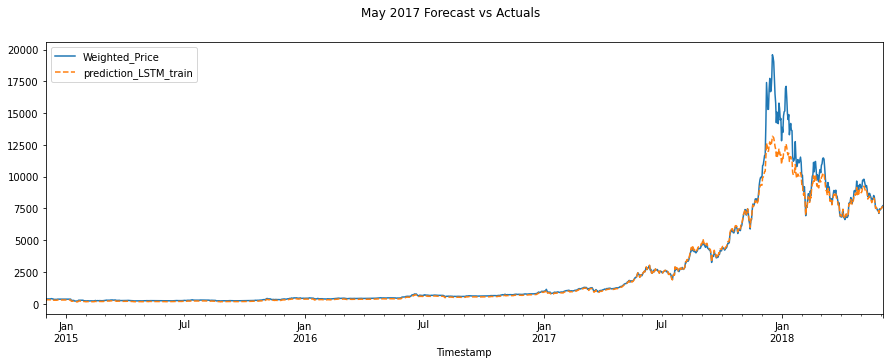

In [ ]:
# Plot the forecast with the actuals
fig , ax = plt.subplots(1, figsize = (15,5))
bit_train_lstm[['Weighted_Price','prediction_LSTM_train']].plot(ax = ax, style = ['-','--'])
#ax.set_xbound(lower = '2017-12-09', upper = '2017-1-23')
plt.suptitle("May 2017 Forecast vs Actuals")
plt.show()

In [ ]:
# evaluation
# train
print(np.sqrt(metrics.mean_squared_error(bit_train_lstm['Weighted_Price'],bit_train_lstm['prediction_LSTM_train'])))

# test
print(np.sqrt(metrics.mean_squared_error(bit_test_lstm['Weighted_Price'],bit_test_lstm['prediction_LSTM'])))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

696.8508112565128


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

94.93535272814006


In [ ]:
# evaluation 2
test_xbound = bit_test_lstm[(bit_test_lstm.index >= '2018-06-09') & (bit_test_lstm.index <= '2018-06-23')]
print(np.sqrt(metrics.mean_squared_error(test_xbound['Weighted_Price'],test_xbound['prediction_LSTM'])))
test_xbound['Weighted_Price'].mean()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

86.1075658647289


6703.864845526667